# Example Notebook to load data

### Library imports

In [1]:
import sys # os stands for "operating system" and includes read/write routines etc. 
import mkl
from src import utils # this is our own library of functions
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import pandas as pd

sns.set_context("talk")
mkl.set_num_threads(10)
sys.path.insert(0,r'C:\Users\WinDesktopMP\Documents\suite2p')
%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\Users\WinDesktopMP\anaconda3\envs\suite2p\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [2]:
exp_db = []
exp_db = utils.add_exp(exp_db, 'DR10', '2022_07_11','1')
exp_db = utils.add_exp(exp_db, 'DR11', "2022_08_04","1")
exp_db = utils.add_exp(exp_db, 'DR12', "2022_08_04","1")
exp_db = utils.add_exp(exp_db, 'TX80', '2022_06_17', '1')
exp_db = utils.add_exp(exp_db, 'L1_A3', '2022_06_09', '2')
exp_db = utils.add_exp(exp_db, 'TX91', '2022_07_28', '2')
timeline_block = [None,None,None,None,None,None] # timeline block to select, when None it selects by default the timeline corresponding to the block in exp_db
frames_per_folder = [0,0,0,0,0,0] # when suite2p process multiple blocks you need to specify which one you want, 0 correspond to select the first block (ie, the first that suite2p processed)

In [3]:
Sessions = utils.build_sessions(exp_db, frames_per_folder, timeline_block, dual_plane=True, baseline=True)

Session: 0
planes: 20


100%|██████████| 20/20 [06:28<00:00, 19.41s/it]


total neurons: 56096
Session: 1
planes: 20


100%|██████████| 20/20 [04:53<00:00, 14.66s/it]


total neurons: 50810
Session: 2
planes: 20


100%|██████████| 20/20 [05:08<00:00, 15.42s/it]


total neurons: 54582
Session: 3
planes: 20


100%|██████████| 20/20 [06:29<00:00, 19.49s/it]


total neurons: 59181
Session: 4
planes: 20


100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


total neurons: 21119


c:\users\windesktopmp\documents\dprime\passivestim\src\utils.py:240: RuntimeWarning: invalid value encountered in true_divide
  ss = ss / np.mean(ss ** 2, 1)[:, np.newaxis, :] ** 0.5


Session: 5
planes: 20


100%|██████████| 20/20 [06:18<00:00, 18.94s/it]


total neurons: 73826


In [4]:
summ_id = []
summ_date = []
summ_block = []
summ_layer = []
summ_traintex = []
summ_acc = []
summ_margin = []
summ_catpair = []
summ_sess = []
n_categories = 8 
n_samples = 4
n_pairs = 28 
layers = [1,2]

In [5]:
for sess in range(len(exp_db)):
    acurracy_per_layer = []
    spop_per_layer = []
    neurons_per_layer = []
    margin_per_layer = []
    mean_margin_L1 = []
    mean_margin_L2 = []
    Sessions[sess].cats, Sessions[sess].stim_idx, Sessions[sess].nreps = utils.get_stim_class_and_samples_ix(Sessions[sess].subset_stim, n_categories=8, samples_per_cat=4)
    for layer in layers:
        accuracy, pairs, spops, cat_dict, selected_neurons = utils.PairwiseDprimeDecoder(Sessions[sess].neurons_atframes, Sessions[sess].stim_idx, Sessions[sess].iplane, Sessions[sess].cats,
                                                                        n_categories = n_categories, n_samples = n_samples, layer = layer , avg_reps = True)
        gen_marg = utils.get_generalization_margings(spops, n_pairs = n_pairs, n_textures = n_samples)
        acurracy_per_layer.append(accuracy)
        spop_per_layer.append(spops)
        margin_per_layer.append(gen_marg)
        neurons_per_layer.append(selected_neurons)

    for pair in range(n_pairs):
        mean_margin_L1.append(utils.get_margin_per_category(margin_per_layer[0],pair,avg=True))
        mean_margin_L2.append(utils.get_margin_per_category(margin_per_layer[1],pair,avg=True))

    Sessions[sess].acurracy_per_layer = np.array(acurracy_per_layer)
    Sessions[sess].spop_per_layer = np.array(spop_per_layer)
    Sessions[sess].dprime_neurons_per_layer = np.array(neurons_per_layer)
    Sessions[sess].margin_per_layer = np.array(margin_per_layer)
    Sessions[sess].mean_margin_L1 = np.array(mean_margin_L1)
    Sessions[sess].mean_margin_L2 = np.array(mean_margin_L2)
    Sessions[sess].cat_pairs = utils.categorypairs_parser(cat_dict,pairs)

    # create a summary 
    summ_id.append([Sessions[sess].name]*n_pairs*n_samples*len(layers))
    summ_date.append([Sessions[sess].date] * n_pairs*n_samples*len(layers))
    summ_block.append([Sessions[sess].block] * n_pairs*n_samples*len(layers))
    summ_sess.append(np.repeat(sess, n_pairs*n_samples*len(layers)))
    summ_layer.append(np.append(np.repeat(1,n_samples*n_pairs),np.repeat(2,n_samples*n_pairs)))
    summ_traintex.append(np.tile(np.tile(np.arange(n_samples),n_pairs),len(layers)))
    summ_acc.append(Sessions[sess].acurracy_per_layer.reshape((n_pairs*n_samples)*len(layers),-1).flatten())
    summ_margin.append(np.append(Sessions[sess].mean_margin_L1.reshape(n_pairs*n_samples,-1).flatten(),Sessions[sess].mean_margin_L2.reshape(n_pairs*n_samples,-1).flatten()))
    summ_catpair.append(np.tile(np.repeat(np.array(Sessions[sess].cat_pairs),n_samples),len(layers)))

summary_sessions = pd.DataFrame({
"Session": np.concatenate(np.array(summ_sess, dtype=object),axis=0),
"ID": np.concatenate(np.array(summ_id, dtype=object),axis=0),
"Date": np.concatenate(np.array(summ_date, dtype=object),axis=0),
"Block": np.concatenate(np.array(summ_block, dtype=object),axis=0),
"Layer": np.concatenate(np.array(summ_layer, dtype=object),axis=0),
"Training_tex" : np.concatenate(np.array(summ_traintex, dtype=object),axis=0),
"Accuracy": np.concatenate(np.array(summ_acc, dtype=object),axis=0),
"Margin": np.concatenate(np.array(summ_margin, dtype=object),axis=0),
"Category_Pair": np.concatenate(np.array(summ_catpair, dtype=object),axis=0)
})

summary_sessions.head()

8 categories, 32 exemplars, 25 repeats
8 categories, 32 exemplars, 28 repeats
8 categories, 32 exemplars, 26 repeats
8 categories, 32 exemplars, 98 repeats
8 categories, 32 exemplars, 173 repeats
8 categories, 32 exemplars, 41 repeats


,Session,ID,Date,Block,Layer,Training_tex,Accuracy,Margin,Category_Pair
0,0,DR10,2022_07_11,1,1,0,100.0,0.137255,leaves/circles
1,0,DR10,2022_07_11,1,1,1,100.0,0.149098,leaves/circles
2,0,DR10,2022_07_11,1,1,2,75.0,0.122631,leaves/circles
3,0,DR10,2022_07_11,1,1,3,100.0,0.247694,leaves/circles
4,0,DR10,2022_07_11,1,1,0,75.0,0.116608,leaves/dryland


In [6]:
grouped_data = summary_sessions.groupby(["ID","Category_Pair","Layer"]).mean().reset_index()
grouped_data.head()

,ID,Category_Pair,Layer,Session,Date,Block,Training_tex,Accuracy,Margin
0,DR10,circles/dryland,1,0.0,5.055178e+30,277.75,1.5,93.75,0.162159
1,DR10,circles/dryland,2,0.0,5.055178e+30,277.75,1.5,93.75,0.092970
2,DR10,circles/paved,1,0.0,5.055178e+30,277.75,1.5,100.00,0.363230
3,DR10,circles/paved,2,0.0,5.055178e+30,277.75,1.5,100.00,0.184826
4,DR10,circles/rocks,1,0.0,5.055178e+30,277.75,1.5,75.00,0.042457


In [11]:
DRframe = grouped_data[grouped_data["ID"].str.startswith("DR")]
TXframe = grouped_data[~grouped_data["ID"].str.startswith("DR")]

# Accuracy DR 

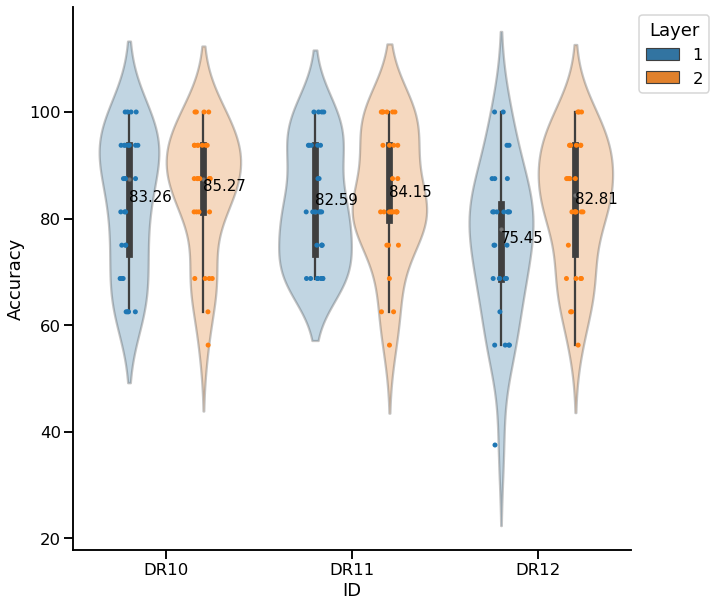

In [203]:
from src import plots
plots.comparisonplot(DRframe, figsize = (10,10), x="ID", y="Accuracy", hue="Layer");

# Accuracy TX

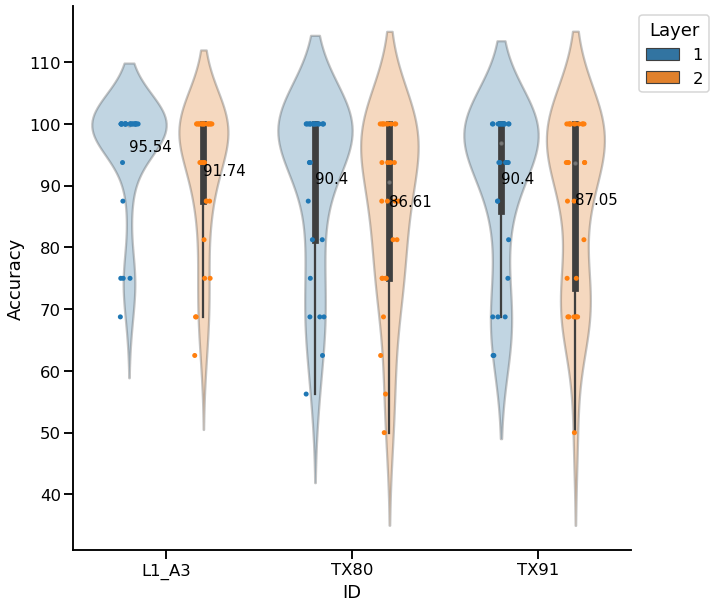

In [13]:
plots.comparisonplot(TXframe, figsize = (10,10), x="ID", y="Accuracy", hue="Layer");

# Margin DR

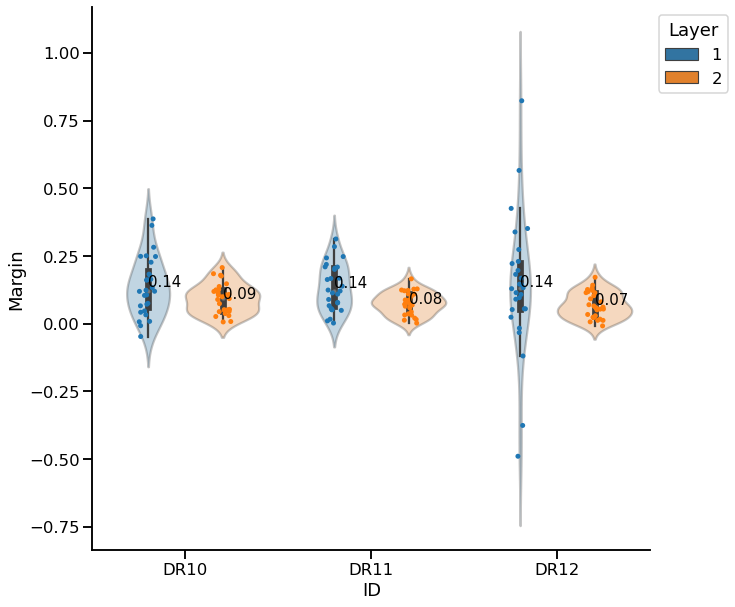

In [36]:
plots.comparisonplot(DRframe, figsize = (10,10), x="ID", y="Margin", hue="Layer");

# Margin TX

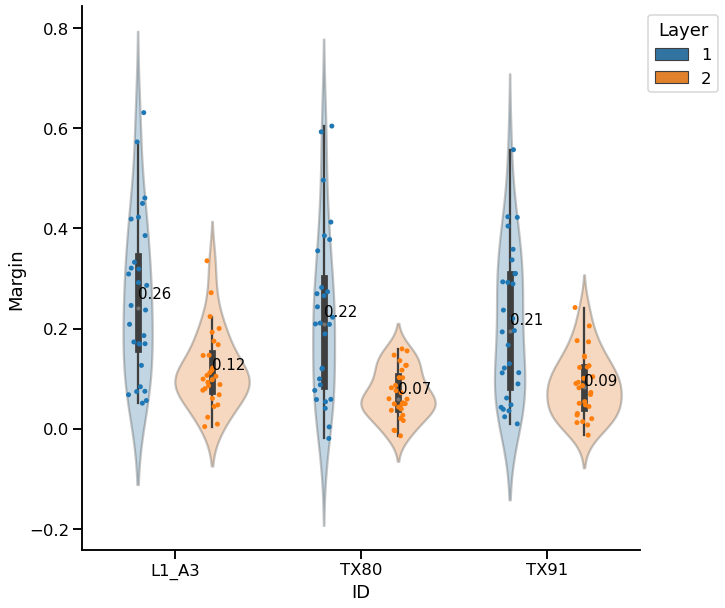

In [35]:
plots.comparisonplot(TXframe, figsize = (10,10), x="ID", y="Margin", hue="Layer");

# Neurons selected in all training pairs
## DR distribution

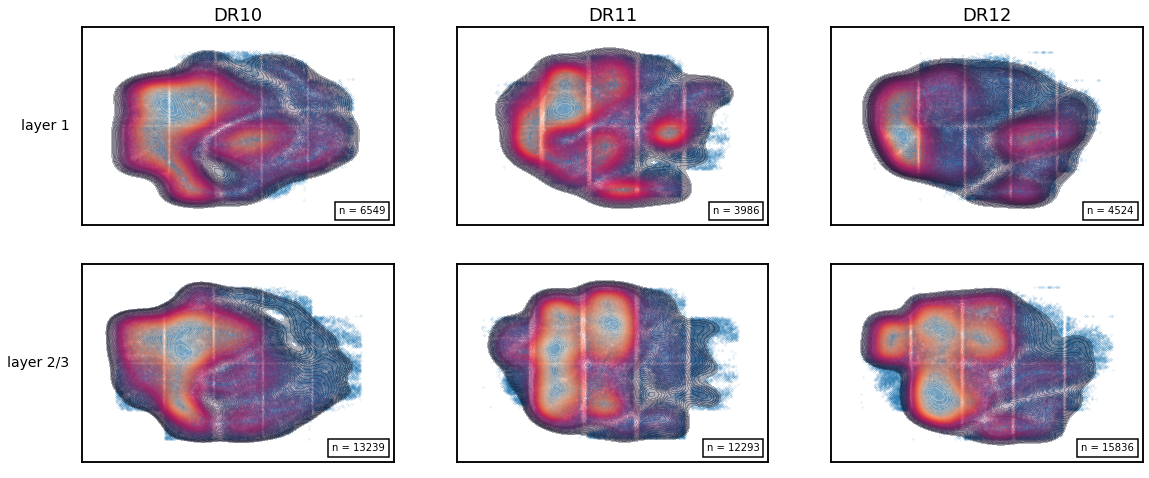

In [201]:
ovrl_gen_neu_per_session, _ = utils.get_generalization_neurons_persess(Sessions[:3], n_pairs=28, n_layers=2)

plots.neurondensity(Sessions[:3], ovrl_gen_neu_per_session)

## TX distribution

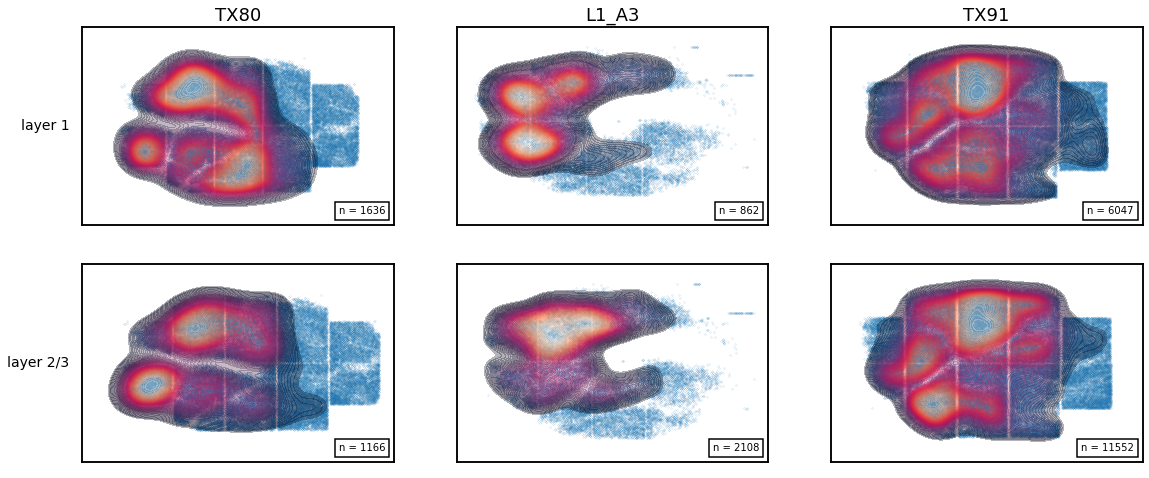

In [202]:
ovrl_gen_neu_per_session_tx, _ = utils.get_generalization_neurons_persess(Sessions[3:], n_pairs=28, n_layers=2)
plots.neurondensity(Sessions[3:], ovrl_gen_neu_per_session_tx)